In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm
sys.path.append('../../../src')

import torch
import torch.nn.functional as F
from torch import tensor
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import Normalizer

from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity
from common.default import PASSING_DEFAULT
from display.display import display
from individual_activity.individual_activity import IndividualActivity

In [116]:
device_idx = 2
device = f'cuda:{device_idx}' if torch.cuda.is_available() else 'cpu'
device

'cuda:2'

# Indivisual Activity をロード

In [3]:
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'passing'},
    {'room_num': '08', 'date': '20210915', 'option': 'passing'},
    {'room_num': '09', 'date': '20210706', 'option': 'passing'}
]

In [4]:
# homography
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = common.homo[room_num][0]
    p_field = common.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [5]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [6]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = path.split('/')[-6] + '_' + path.split('/')[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'date': '20210903', 'option': 'passing'}


100%|██████████| 23/23 [00:05<00:00,  4.06it/s]


{'room_num': '08', 'date': '20210915', 'option': 'passing'}


100%|██████████| 41/41 [00:05<00:00,  6.85it/s]


{'room_num': '09', 'date': '20210706', 'option': 'passing'}


100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


# 特徴量抽出とデータ生成

In [7]:
def extract_features(frame_num, label1, label2, individuals):
    individual1 = individuals[label1]
    pos1 = individual1.get_data('position', frame_num)
    body1 = individual1.get_data('body_vector', frame_num)
    arm1 = individual1.get_data('arm_ext', frame_num)
    wrist1 = [
        individual1.get_keypoints('LWrist', frame_num),
        individual1.get_keypoints('RWrist', frame_num)
    ]
    if pos1 is None or body1 is None or arm1 is None or None in wrist1:
        return None
    
    individual2 = individuals[label2]
    pos2 = individual2.get_data('position', frame_num)
    body2 = individual2.get_data('body_vector', frame_num)
    arm2 = individual2.get_data('arm_ext', frame_num)
    wrist2 = [
        individual2.get_keypoints('LWrist', frame_num),
        individual2.get_keypoints('RWrist', frame_num)
    ]
    if pos2 is None or body2 is None or arm2 is None or None in wrist2:
        return None
    
    # ポジション間の距離
    norm = np.linalg.norm(np.array(pos1) - np.array(pos2), ord=2)
    if norm < 50 or 300 < norm:
        # norm が範囲外の時はデータに加えない
        # plot.ipynb の分布から決定した
        return None
    
    distance_prob = gauss(
        norm,
        mu=PASSING_DEFAULT['gauss_mu'],
        sigma=PASSING_DEFAULT['gauss_sig'])
    
    # 体の向き
    pos1 = np.array(pos1)
    pos2 = np.array(pos2)
    p1p2 = pos2 - pos1
    p2p1 = pos1 - pos2
    p1_sim = cos_similarity(body1, p1p2)
    p2_sim = cos_similarity(body2, p2p1)
    body_direction = np.average([p1_sim, p2_sim])
    
    # 腕の上げ下げ
    arm_ave = np.average([arm1, arm2])
    
    # 手首の距離
    min_norm = np.inf
    for i in range(2):
        for j in range(2):
            norm = np.linalg.norm(
                np.array(wrist1[i]) - np.array(wrist2[j]), ord=2)
            if norm < min_norm:
                min_norm = norm
    distance_prob_wrist = gauss(
        min_norm,
        mu=PASSING_DEFAULT['wrist_gauss_mu'],
        sigma=PASSING_DEFAULT['wrist_gauss_sig'])

    return [distance_prob, body_direction, arm_ave, distance_prob_wrist]

columns = ['distance', 'body direction', 'arm average', 'wrist distance']

In [14]:
x_dict = {}
y_dict = {}
for setting in data_settings:
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    dirs = sorted(glob.glob(f'{common.data_dir}/{room_num}/{date}/{opt}/*'))
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]

    for path in dirs:
        file_num = path.split('/')[-1]
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

        for row in tqdm(csv_data, desc=f'{room_num}, {date}, {file_num}'):
            frame_num = row[0]
            label1 = f'{room_num}_{file_num}_{row[1]}'
            label2 = f'{room_num}_{file_num}_{row[2]}'

            features = extract_features(frame_num, label1, label2, individuals)
            key = str(file_num) + '_' + str(row[1]) + '_' + str(row[2])

            if key not in x_dict:
                x_dict[key] = []
                y_dict[key] = []

            if features is not None:
                x_dict[key].append(features)
                y_dict[key].append(row[3])

09, 20210706, 09: 100%|██████████| 3701/3701 [00:00<00:00, 6048.31it/s]


# 深層学習

In [11]:
BATCH_SIZE = 100
EPOCH = 30

## データセット生成

In [248]:
def create_sequence(x_lst, y_lst, seq_len):
    x_seq = []
    y_seq = []
    for i in range(len(x_lst) - seq_len + 1):
        x_seq.append(x_lst[i:i + seq_len])
        y_seq.append(y_lst[i + seq_len - 1])
        
    return x_seq, y_seq

class MyDataset(Dataset):
    def __init__(self, x_dict, y_dict, **kwargs):
        seq_len = kwargs['seq_len']
        self.x, self.y = [], []
        for key in tqdm(x_dict.keys()):
            x_lst = x_dict[key]
            y_lst = y_dict[key]
            x_seq, y_seq = create_sequence(x_lst, y_lst, seq_len)
            self.x += x_seq
            self.y += y_seq
            
        self.device = kwargs['device']
            
    def __getitem__(self, index):
        return (
            tensor(self.x[index]).float().to(self.device),
            tensor(self.y[index]).float().to(self.device)
        )

    def __len__(self):
        return len(self.x)

In [249]:
random_keys = np.random.choice(
    list(x_dict.keys()),
    size=len(x_dict),
    replace=False
)
train_len = int(len(x_dict) * TRAIN_RATIO)
val_len = int(len(x_dict) * VAL_RATIO)
train_keys = random_keys[:train_len]
val_keys = random_keys[train_len:train_len + val_len]
test_keys = random_keys[train_len + val_len:]

x_train_dict = {key: x_dict[key] for key in train_keys}
y_train_dict = {key: y_dict[key] for key in train_keys}
train_loader = DataLoader(
    MyDataset(x_train_dict, y_train_dict, **kwargs),
    batch_size=BATCH_SIZE,
    shuffle=True
)

x_val_dict = {key: x_dict[key] for key in val_keys}
y_val_dict = {key: y_dict[key] for key in val_keys}
val_loader = DataLoader(
    MyDataset(x_val_dict, y_val_dict, **kwargs),
    batch_size=BATCH_SIZE,
    shuffle=False
)

x_test_dict = {key: x_dict[key] for key in test_keys}
y_test_dict = {key: y_dict[key] for key in test_keys}
test_loader = DataLoader(
    MyDataset(x_test_dict, y_test_dict, **kwargs),
    batch_size=BATCH_SIZE,
    shuffle=False
)

100%|██████████| 615/615 [00:00<00:00, 38599.62it/s]
0it [00:00, ?it/s]


## モデル作成

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc = nn.Sequential(
            nn.Linear(32 * 4 * 4, 64),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net()
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

/opt/conda/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /tmp/pip-req-build-h953rg2q/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## 学習

In [18]:
train_loss_value=[]      #trainingのlossを保持するlist
train_acc_value=[]       #trainingのaccuracyを保持するlist

for epoch in range(EPOCH):
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    sum_loss = 0.0          #lossの合計
    sum_correct = 0         #正解率の合計
    sum_total = 0           #dataの数の合計
    
    #train dataを使ってテストをする(パラメータ更新がないようになっている)
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()                            # lossを足していく
        _, predicted = outputs.max(1)                      # 出力の最大値の添字(予想位置)を取得
        sum_total += labels.size(0)                        # labelの数を足していくことでデータの総和を取る
        sum_correct += (predicted == labels).sum().item()  # 予想位置と実際の正解を比べ,正解している数だけ足す

    print("epoch:{}, train mean loss={}, accuracy={}".format(
        epoch, 
        sum_loss * BATCH_SIZE / len(trainloader.dataset),
        float(sum_correct / sum_total)
    ))  # lossとaccuracy出力
    train_loss_value.append(sum_loss * BATCH_SIZE / len(trainloader.dataset))  # traindataのlossをグラフ描画のためにlistに保持
    train_acc_value.append(float(sum_correct / sum_total))  # traindataのaccuracyをグラフ描画のためにlistに保持

epoch:0, train mean loss=0.009200530185543516, accuracy=0.9974181713865511
epoch:1, train mean loss=0.007728979108764586, accuracy=0.9977373645954125
epoch:2, train mean loss=0.006500807054515155, accuracy=0.9979555472951406
epoch:3, train mean loss=0.005400859443012694, accuracy=0.99818989167633
epoch:4, train mean loss=0.004600652789331272, accuracy=0.9986020145535942
epoch:5, train mean loss=0.004276973407425254, accuracy=0.9987030250627276
epoch:6, train mean loss=0.004183123883228223, accuracy=0.9987434292663808
epoch:7, train mean loss=0.004446642333703546, accuracy=0.9988080759922262
epoch:8, train mean loss=0.004237444258488462, accuracy=0.9986181762350554
epoch:9, train mean loss=0.003955245576611341, accuracy=0.9987838334700342
epoch:10, train mean loss=0.0027532504738561614, accuracy=0.9991151479399917
epoch:11, train mean loss=0.0033314952880682115, accuracy=0.998913126921725
epoch:12, train mean loss=0.0032404810368686335, accuracy=0.9989333290235516
epoch:13, train mean l

KeyboardInterrupt: 

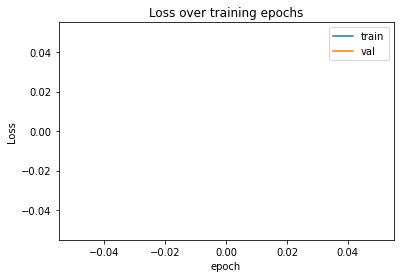

In [201]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('Loss over training epochs')
plt.legend(['train','val'])
plt.show()

01_4_17


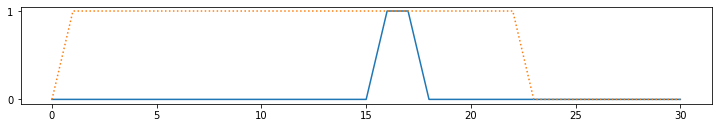

02_1_2


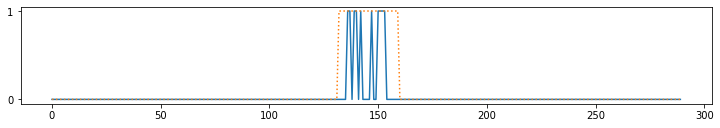

02_2_4


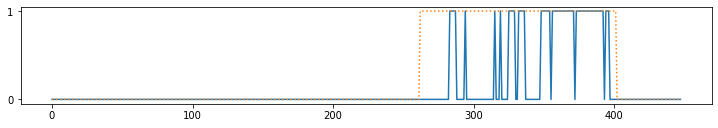

03_1_4


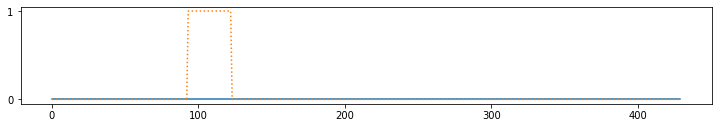

05_0_4


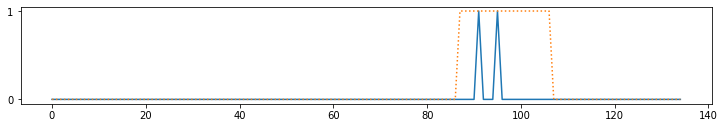

06_0_8


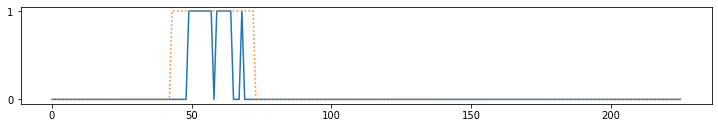

07_0_8


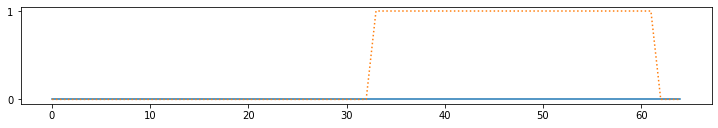

08_0_8


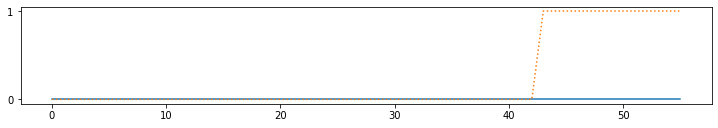

09_0_9


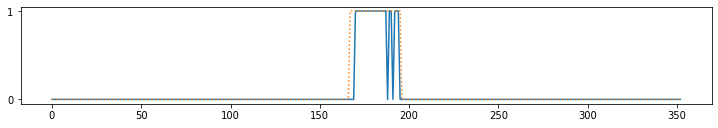

10_4_13


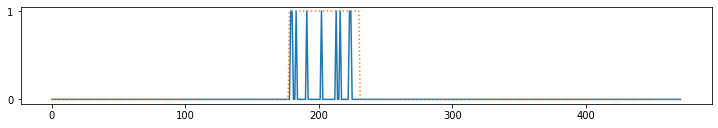

11_2_6


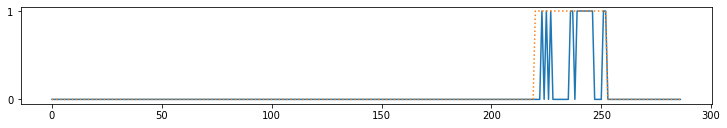

13_1_9


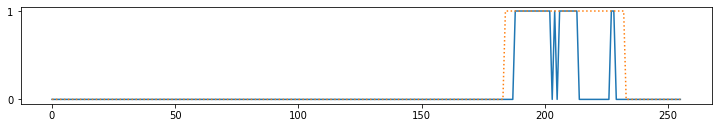

15_9_20


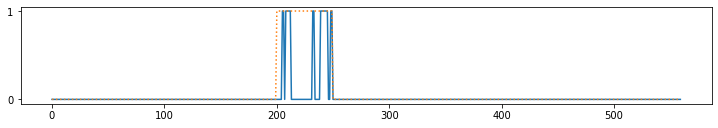

18_1_10


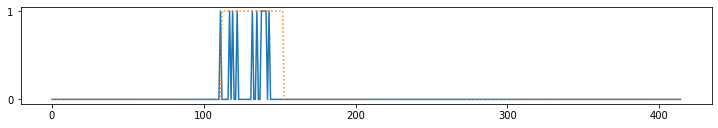

19_0_4


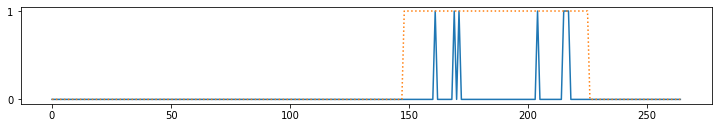

20_2_8


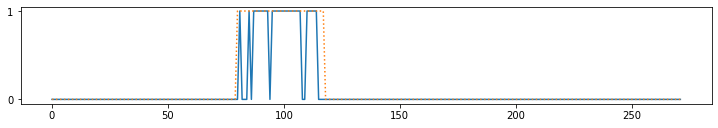

22_0_5


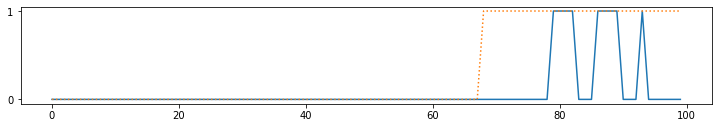

23_9_14


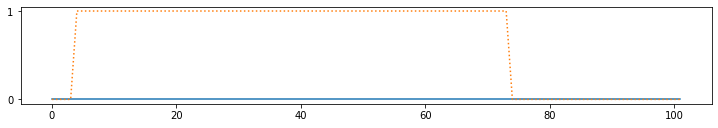

In [19]:
train_pred = []
for key, x, y in zip(x_train_dict.keys(), x_train_dict.values(), y_train_dict.values()):
    if 1 not in y:
        continue
    
    # nomalize and reshape
    x = normalize(x, scaler_train)
    x = np.array(x).reshape(-1, 1, 17, 17)
    x = torch.Tensor(x).float()
    
    # predict
    pred = net(x).max(1)[1]
    train_pred += pred.tolist()
    
    print(key)
    plt.figure(figsize=(10, 1.5))
    # plt.rcParams["font.size"] = 20
    # plt.rcParams["font.family"] = 'Times New Roman'
    plt.plot(pred, label='pred')
    plt.plot(y, linestyle=':', label='ground truth')
    plt.ylim((-0.05, 1.05))
    plt.yticks([0, 1])
    plt.subplots_adjust(left=0.04, right=1, bottom=0.1, top=1)

    plt.show()

In [96]:
path = f'{common.root}/model/pass_model_lstm.pth'
torch.save(model, path)